In [ ]:
# Upgrade Oracle ADS to pick up latest features and maintain compatibility with Oracle Cloud Infrastructure.
!pip install -U oracle-ads

Oracle Data Science service sample notebook.

Copyright (c) 2022 Oracle, Inc. All rights reserved. Licensed under the [Universal Permissive License v 1.0](https://oss.oracle.com/licenses/upl).

***

# <font color="red">Introduction to the Oracle Cloud Infrastructure Data Flow Studio</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color="teal">Oracle Cloud Infrastructure Data Science Service.</font></p>

---
# Overview:

This notebook demonstrates how to run interactive Spark workloads on a long lasting [Oracle Cloud Infrastructure Data Flow](https://docs.oracle.com/en-us/iaas/data-flow/using/home.htm) cluster through [Apache Livy](https://livy.apache.org/) integration. **Data Flow Spark Magic** is used for interactively working with remote Spark clusters through Livy, a Spark REST server, in Jupyter notebooks. It includes a set of magic commands for interactively running Spark code.

Comnatible conda pack: [PySpark 3.2 and Data Flow](https://docs.oracle.com/iaas/data-science/using/conda-pyspark-fam.htm) for CPU on Python 3.8

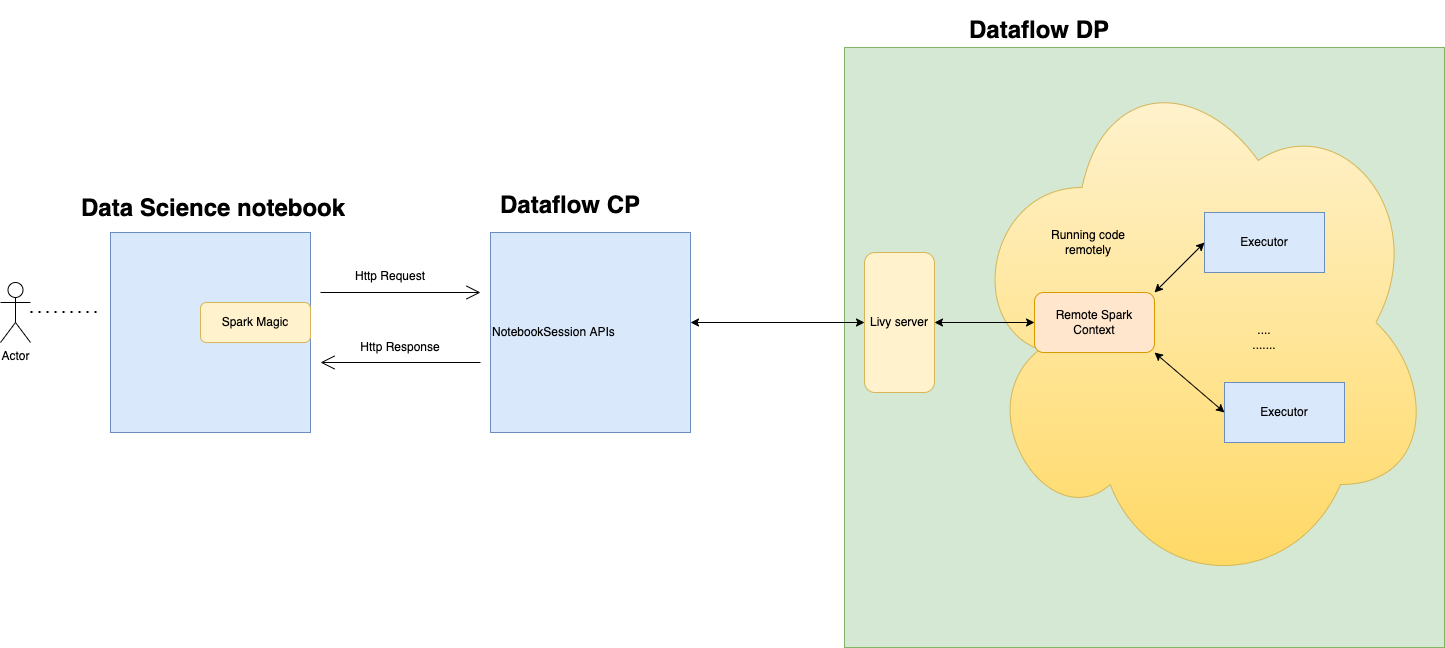

---

## Contents:

- <a href='#pre-requisites'>1. Pre-requisites</a>
    - <a href='#policies'>1.2 Policies</a>
    - <a href='#prerequisites_helpers'>1.3 Helpers</a>
    - <a href='#prerequisites_authentication'>1.4 Authentication</a>
    - <a href='#prerequisites_variables'>1.5 Variables</a>    
- <a href='#dataflow_magic'>2. Data Flow Spark Magic</a>
    - <a href='#load_extension'>2.1. Load Extension</a>
    - <a href='#create_session'>2.2. Create Session</a>
        - <a href='#create_session_flex_shape'>2.2.1. Example command for Flex shapes</a>
        - <a href='#create_session_dynamic_allocation'>2.2.2. Example command for Spark dynamic allocation</a>
        - <a href='#create_session_third_party_libraries'>2.2.3. Example command with third-party libraries</a>
        - <a href='#create_session_hive_metastore'>2.2.4. Example command with the Data Catalog Hive Metastore</a>
        - <a href='#create_session_custom_conda'>2.2.5. Example command with the published conda environment</a>
    - <a href='#update_session'>2.3. Update Session</a>
    - <a href='#configure_session'>2.4. Configure Session</a>
    - <a href='#stop_session'>2.5. Stop Session</a>
    - <a href='#activate_session'>2.6. Activate Session</a>
    - <a href='#using_existing_session'>2.7. Use existing Session</a>
- <a href='#basic_examples'>3. Basic Spark Usage Examples</a>
    - <a href='#examples_pyspark'>3.1. PySpark</a>
    - <a href='#examples_sparksql'>3.2. Spark SQL</a>
    - <a href='#examples_autoviz'>3.3. Autovisualization Widget</a>
- <a href='#cleanup'>4. Clean Up</a> 
- <a href='#ref'>5. References</a>   

---

<a id='pre-requisites'></a>
# 1. Pre-requisites 

Data Flow Sessions are accessible through the following conda environment: 

* **PySpark 3.2 and Data Flow 2.0 (pyspark32_p38_cpu_v2)**

You can customize `pypspark32_p38_cpu_v2`, publish it, and use it as a runtime environment for a Data Flow Session. 

<a id='policies'></a>
## 1.2. Policies
This section covers the creation of dynamic groups and policies needed to use the service.

* [Data Flow Policies](https://docs.oracle.com/iaas/data-flow/using/policies.htm/)
* [Getting Started with Data Flow](https://docs.oracle.com/iaas/data-flow/using/dfs_getting_started.htm)
* [About Data Science Policies](https://docs.oracle.com/iaas/data-science/using/policies.htm)
* [Data Catalog Metastore](https://docs.oracle.com/en-us/iaas/data-catalog/using/metastore.htm)

<a id="prerequisites_helpers"></a>
## 1.3 Helpers
This section provides a helper method used across the notebook to prepare arguments for the magic commands. This function is particularly useful when you want to pass Python variables as arguments to the spark magic commands 

In [ ]:
import json


def prepare_command(command: dict) -> str:
    """Converts dictionary command to the string formatted commands."""
    return f"'{json.dumps(command)}'"

<a id="prerequisites_authentication"></a>
## 1.4. Authentication
The [Oracle Accelerated Data Science SDK (ADS)](https://docs.oracle.com/iaas/tools/ads-sdk/latest/index.html) controls the authentication mechanism with the Data Flow Session Spark cluster.<br> 
To setup authentication use the ```ads.set_auth("resource_principal")``` or ```ads.set_auth("api_key")```. 

In [ ]:
import ads

ads.set_auth("resource_principal")  # Supported values: resource_principal, api_key

<a id="prerequisites_variables"></a>
## 1.5. Variables
To run this notebook, you must provide some information about your tenancy configuration. To connect to the HIVE metastore, replace `<metastore_id>` with the OCID for the HIVE metastore. Connecting to the metastore is optional.  

To create and run a Data Flow session, you must specify a `<compartment_id>` and bucket `<logs_bucket_uri>` for storing logs. These resources must be in the same compartment.

In [ ]:
import os

compartment_id = os.environ.get("NB_SESSION_COMPARTMENT_OCID")
logs_bucket_uri = "oci://<bucket_name>@<namespace>/<prefix>"
metastore_id = "<metastore_id>"

<a id="dataflow_magic"></a>
# 2. Data Flow Spark Magic
Data Flow Spark Magic commands allow you to interactively work with Data Flow Spark clusters (sessions) in Jupyter notebooks through the Livy REST API. It provides a set of Jupyter Notebook cell magic commands to turn Jupyter into an integrated Spark development environment for remote clusters. 

**Data Flow Magic allows you to:**

* Run Spark code against Data Flow remote Spark cluster
* Create a Data Flow Spark Session with SparkContext and HiveContext against Data Flow remote Spark cluster
* Capture the output of Spark queries as a local Pandas data frame to interact easily with other Python libraries (e.g. matplotlib)

<a id="load_extension"></a>
### 2.1. Load Spark Magic Commands and Getting Help
Data Flow Spark Magic is a JupyterLab extension that you need to activate in your notebook using the `%load_ext dataflow.magics` magic command.<br>
After the extension is activated, the `%help` command can be used to get the list of supported commands.

In [ ]:
%load_ext dataflow.magics

The `%help` command gives you a list of all the available commands, along with a list of their arguments and example calls. 

In [ ]:
%help

If you want to access the docstrings of any magic command and figure out what arguments to provide, simply add `?` at then end of the command.

In [ ]:
?%create_session

### 2.2. Create Session
To create a new Data Flow cluster session use the `%create_session` magic command.

<a id="create_session_flex_shape"></a>
#### 2.2.1. Example command for Flex shapes
In the example below the new Data Flow cluster session is started with the basic configuration on the flexible shapes for driver and executor.<br>The [VM.Standard.E4.Flex](https://docs.oracle.com/en-us/iaas/Content/Compute/References/computeshapes.htm) is used for both driver and executor shapes. For each one, we independently set the number of OCPUs and the amount of primary memory. The cluster is active for 1440 minutes. 

Note that the parameter `fs.oci.client.hostname": "https://objectstorage.us-ashburn-1.oraclecloud.com` is required for running the Spark samples below. The parameter `fs.oci.client.hostname` specifies the region endpoint where the data is stored on Object Storage. It is required if your cluster is running in a different region than the object storage bucket. 

In the code samples below, the dataset is publicly available but hosted in an Object Storage bucket in the Ashburn region. By specifying the region of the bucket, we can ensure that the cluster will access the data no matter what the cluster region is. 

In [ ]:
command = prepare_command(
    {
        "compartmentId": compartment_id,
        "displayName": "TestDataFLowSessionFlexShapes",
        "language": "PYTHON",
        "sparkVersion": "3.2.1",
        "numExecutors": 1,
        "driverShape": "VM.Standard.E4.Flex",
        "executorShape": "VM.Standard.E4.Flex",
        "driverShapeConfig": {"ocpus": 2, "memoryInGBs": 32},
        "executorShapeConfig": {"ocpus": 2, "memoryInGBs": 32},
        "type": "SESSION",
        "logsBucketUri": logs_bucket_uri,
        "configuration": {
            "fs.oci.client.hostname": "https://objectstorage.us-ashburn-1.oraclecloud.com"
        },
    }
)

%create_session -l python -c $command

<a id="create_session_dynamic_allocation"></a>
#### 2.2.2. Example command for Spark dynamic allocation (aka auto-scaling)
To help you save resources and reduce time on management, Spark [dynamic allocation](https://docs.oracle.com/iaas/data-flow/using/dynamic-alloc-about.htm#dynamic-alloc-about) is now enabled in Data Flow.

Resource planning for data processing is a complex task. Resource usage is a function of the volume of the data. Day-to-day volumes of data can vary, meaning the computational resource required changes, too.

You can define a Data Flow cluster based on a range of executors, instead of just a fixed number of executors. Spark provides a mechanism to dynamically adjust the resources application occupies based on the workload. The application might relinquish resources if they are no longer used and request them again later when there is demand.

In [ ]:
command = prepare_command(
    {
        "compartmentId": compartment_id,
        "displayName": "TestDataFLowSessionDynamicAllocation",
        "language": "PYTHON",
        "sparkVersion": "3.2.1",
        "numExecutors": 2,
        "driverShape": "VM.Standard.E4.Flex",
        "executorShape": "VM.Standard.E4.Flex",
        "driverShapeConfig": {"ocpus": 2, "memoryInGBs": 32},
        "executorShapeConfig": {"ocpus": 2, "memoryInGBs": 32},
        "configuration": {
            "fs.oci.client.hostname": "https://objectstorage.us-ashburn-1.oraclecloud.com",
            "spark.dynamicAllocation.enabled": "true",
            "spark.dynamicAllocation.shuffleTracking.enabled": "true",
            "spark.dynamicAllocation.minExecutors": "1",
            "spark.dynamicAllocation.maxExecutors": "4",
            "spark.dynamicAllocation.executorIdleTimeout": "60",
            "spark.dynamicAllocation.schedulerBacklogTimeout": "60",
            "spark.dataflow.dynamicAllocation.quotaPolicy": "min",
        },
    }
)

%create_session -l python -c $command

<a id="create_session_third_party_libraries"></a>    
#### 2.2.3. Example command with third-party libraries
            
The Data Flow Sessions support [custom dependencies](https://docs.oracle.com/iaas/data-flow/using/third-party-libraries.htm) in the form of Python wheels or virtual environments. You might want to make native code or other assets available within your Spark runtime. The dependencies can be attached by using `archiveUri` attribute.

In [ ]:
command = prepare_command(
    {
        "compartmentId": compartment_id,
        "displayName": "TestDataFLowSessionThirdPartyDependencies",
        "language": "PYTHON",
        "sparkVersion": "3.2.1",
        "numExecutors": 1,
        "driverShape": "VM.Standard.E4.Flex",
        "executorShape": "VM.Standard.E4.Flex",
        "driverShapeConfig": {"ocpus": 1, "memoryInGBs": 16},
        "executorShapeConfig": {"ocpus": 1, "memoryInGBs": 16},
        "type": "SESSION",
        "logsBucketUri": logs_bucket_uri,
        "archiveUri": "oci://<bucket_name>@<namespace>/<zip_archive>",
        "configuration": {
            "fs.oci.client.hostname": "https://objectstorage.us-ashburn-1.oraclecloud.com"
        },
    }
)

%create_session -l python -c $command

<a id="create_session_hive_metastore"></a>
#### 2.2.4. Example command with the Data Catalog Hive Metastore
            
The [Data Catalog Hive Metastore](https://docs.oracle.com/iaas/data-catalog/using/metastore.htm) provides schema definitions for objects in structured and unstructured data assets. The Metastore is the central metadata repository to understand tables backed by files on Object Storage. As a Data Flow user, you can access the Data Catalog Metastore to securely store and retrieve schema definitions for data assets. For integration with Data Flow, the Metastore provides an invocation endpoint to Data Flow. This endpoint exposes the Hive Metastore interface. [Apache Hive](https://hive.apache.org/) is a data warehousing framework that facilitates read, write, or manage operations on large datasets residing in distributed systems. A Hive Metastore is the central repository of metadata for a Hive cluster. It stores metadata for data structures such as databases, tables, and partitions in a relational database, backed by files on Object Storage. Apache Spark SQL makes use of a Hive Metastore for this purpose.

In [ ]:
command = prepare_command(
    {
        "compartmentId": compartment_id,
        "displayName": "TestDataFLowSessionDataCatalogHiveMetastore",
        "language": "PYTHON",
        "sparkVersion": "3.2.1",
        "numExecutors": 1,
        "driverShape": "VM.Standard.E4.Flex",
        "executorShape": "VM.Standard.E4.Flex",
        "driverShapeConfig": {"ocpus": 1, "memoryInGBs": 16},
        "executorShapeConfig": {"ocpus": 1, "memoryInGBs": 16},
        "type": "SESSION",
        "logsBucketUri": logs_bucket_uri,
        "metastoreId": "<ocid1.datacatalogmetastore...>",
        "configuration": {
            "fs.oci.client.hostname": "https://objectstorage.us-ashburn-1.oraclecloud.com"
        },
    }
)

%create_session -l python -c $command

<a id="create_session_custom_conda"></a>
#### 2.2.5. Example command with the published conda environment
            
You can use a published conda environment as a Data Flow runtime environment. 
* [Creating a Custom Conda Environment](https://docs.oracle.com/en-us/iaas/data-science/using/conda_create_conda_env.htm)
* [How to create a new conda environment in OCI Data Science](https://blogs.oracle.com/ai-and-datascience/post/creating-a-new-conda-environment-from-scratch-in-oci-data-science)
* [Publishing a Conda Environment to an Object Storage Bucket in Your Tenancy](https://docs.oracle.com/en-us/iaas/data-science/using/conda_publishs_object.htm#:~:text=You%20can%20publish%20a%20conda%20environment%20that%20you%20have%20installed,persist%20them%20across%20notebook%20sessions.)

The path to the published conda environment can be copied from the [Environment Explorer](https://docs.oracle.com/en-us/iaas/data-science/using/conda_viewing.htm). <br>

Example path : `oci://<your-bucket>@<your-tenancy-namespace>/conda_environments/cpu/PySpark 3.2 and Data Flow/2.0/pyspark32_p38_cpu_v2#conda`

In [ ]:
custom_conda_environment_uri = "oci://<your-bucket>@<your-tenancy-namespace>/<your-path-to-the-conda-environment>#conda"

command = prepare_command(
    {
        "compartmentId": compartment_id,
        "displayName": "TestDataFLowSessionDataCatalogHiveMetastore",
        "language": "PYTHON",
        "sparkVersion": "3.2.1",
        "numExecutors": 1,
        "driverShape": "VM.Standard.E4.Flex",
        "executorShape": "VM.Standard.E4.Flex",
        "driverShapeConfig": {"ocpus": 1, "memoryInGBs": 16},
        "executorShapeConfig": {"ocpus": 1, "memoryInGBs": 16},
        "type": "SESSION",
        "logsBucketUri": logs_bucket_uri,
        "configuration": {
            "spark.archives": custom_conda_environment_uri,
            "fs.oci.client.hostname": "https://objectstorage.us-ashburn-1.oraclecloud.com",
        },
    }
)

%create_session -l python -c $command

Use the `%status` magic command to check the status of the current session.

In [ ]:
%status

Use the `%config` magic command to see the configuration of the current session.

In [ ]:
%config

<a id="update_session"></a>
### 2.3. Update Session
You can modify the configuration of your running session using the `%update_session` command. For example, Data Flow Sessions can last up to 7 days or 10080 mins (168 hours) (**maxDurationInMinutes**) and have default idle timeout value of 480 mins (8 hours)(**idleTimeoutInMinutes**). Here's how you would update your session and configure for a max session time:<br>

In [ ]:
%update_session -i '{"maxDurationInMinutes": 1440, "idleTimeoutInMinutes": 420}'

In [ ]:
%status

<a id="configure_session"></a>
### 2.4. Configure Session
Configure session allows you to create a cluster configuration that can be later used to create a session. There is a force flag `-f` for immediate effect of the configuration change, in that case the running cluster session will be dropped and recreated.

In [ ]:
command = prepare_command(
    {
        "driverShape": "VM.Standard.E4.Flex",
        "executorShape": "VM.Standard.E4.Flex",
        "driverShapeConfig": {"ocpus": 2, "memoryInGBs": 32},
        "executorShapeConfig": {"ocpus": 2, "memoryInGBs": 32},
        "numExecutors": 2,
        "configuration": {
            "fs.oci.client.hostname": "https://objectstorage.us-ashburn-1.oraclecloud.com"
        },
    }
)

%configure_session -i $command -f

In [ ]:
%config

<a id="stop_session"></a>
### 2.5. Stop Session
To stop the current session use the `%stop_session` magic command. You don't need to provide any arguments for this command. The current active cluster will be stopped. All data in memory will be lost. 

<a id="activate_session"></a>
### 2.6. Activate Session
To re-activate the existing session use the `%activate_session` magic command. The `application_id` can be taken from the console UI.

In [ ]:
command = prepare_command(
    {
        "compartmentId": "<compartment_id>",
        "displayName": "<display_name>",
        "applicationId": "<application_id>",
    }
)

%activate_session -l python -c $command

<a id="using_existing_session"></a>
### 2.7. Use existing Session
To connect to the existing session use the `%use_session` magic command. 

In [ ]:
%use_session -s <application_id>

<a id="basic_examples"></a>
# 3. Basic Spark Usage Examples

A SparkContext (`sc`) and HiveContext (`sqlContext`) are automatically created in the session cluster. The magic commands include the `%%spark` command to run Spark commands in the cluster. You can access information about the Spark application, define a dataframe where results are to be stored, modify the configuration, and so on.

The `%%spark` magic command comes with a number of parameters that allow you to interact with the Data Flow Spark cluster. **Any cell content that starts with the `%%spark` command will be executed in the remote Spark cluster.**

<a id="examples_pyspark"></a>
### 3.1. PySpark
The `sc` variable represents the Spark context and it's available when the `%%spark` magic command is used. The next cell is a toy example of how to use `sc` in a Data Flow Spark Magic cell. The cell calls the [`.parallelize()`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.SparkContext.parallelize.html) method, which creates an [RDD](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.html), `numbers`, from a list of numbers. Information about the RDD is printed. The [`.toDebugString()`](https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.RDD.toDebugString.html) method returns a description of the RDD.

In [ ]:
%%spark
print(sc.version)

In [ ]:
%%spark
numbers = sc.parallelize([4, 3, 2, 1])
print(f"First element of numbers is {numbers.first()}")
print(f"The RDD, numbers, has the following description\n{numbers.toDebugString()}")

<a id="examples_sparksql"></a>
### 3.2. Spark SQL
Using the `-c sql` option allows you to run Spark SQL commands in a cell. In this section, the [NYC Taxi and Limousine Commission (TLC) Data](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) dataset is used. The size of the dataset is around **35GB**. 

The next cell reads the dataset into a Spark dataframe, and then saves it as a view used to demonstrate Spark SQL.

In [ ]:
%%spark
df_nyc_tlc = spark.read.parquet("oci://hosted-ds-datasets@bigdatadatasciencelarge/nyc_tlc/201[1,2,3,4,5,6,7,8]/**/data.parquet", header=False, inferSchema=True)
df_nyc_tlc.show()

df_nyc_tlc.createOrReplaceTempView("nyc_tlc")

The following cell uses the `-c sql` option to tell Data Flow Spark Magic that the contents of the cell is SparkSQL. The `-o <variable>` option takes the results of the Spark SQL operation and stores it in the defined variable. In this case, the `df_nyc_tlc` will be a Pandas dataframe that is available to be used in the notebook.

In [ ]:
%%spark -c sql -o df_nyc_tlc
SELECT vendor_id, passenger_count, trip_distance, payment_type FROM nyc_tlc LIMIT 1000;

In [ ]:
type(df_nyc_tlc)

In [ ]:
df_nyc_tlc.head()

In [ ]:
%%spark -c sql -o df_tables
SHOW TABLES

Similarly you can use `sqlContext` to query the table

In [ ]:
%%spark
df_nyc_tlc = sqlContext.sql("SELECT * FROM nyc_tlc LIMIT 1000")
df_nyc_tlc.show()

<a id="examples_autoviz"></a>
### 3.3. Autovisualization Widget
Data Flow Spark Magic comes with [autovizwidget](https://github.com/jupyter-incubator/sparkmagic/tree/master/autovizwidget) and enables the visualization of Pandas dataframes. The `display_dataframe()` function takes a Pandas dataframe as a parameter and generates an interactive GUI in the notebook. It has tabs that allow the visualization of the data in various forms such as tabular, pie charts, scatter plots, and area and bar graphs.

The following cell calls `display_dataframe()` with the `df_nyc_tlc` dataframe created in the <a href='#sparkmagic_examples_sparksql'>Spark SQL</a> section of the notebook.

In [ ]:
from autovizwidget.widget.utils import display_dataframe

display_dataframe(df_nyc_tlc)

<a id='cleanup'></a>
# 4. Clean Up
Use the `%stop_session` magic command to stop your active Data Flow session.

In [ ]:
%stop_session

<a id='ref'></a>
# 5. References

- [ADS Library Documentation](https://accelerated-data-science.readthedocs.io/en/latest/index.html)
- [Data Science YouTube Videos](https://www.youtube.com/playlist?list=PLKCk3OyNwIzv6CWMhvqSB_8MLJIZdO80L)
- [OCI Data Science Documentation](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm)
- [Oracle Data & AI Blog](https://blogs.oracle.com/datascience/)
- [Data Flow Policies](https://docs.oracle.com/iaas/data-flow/using/policies.htm/)
- [Getting Started with Data Flow](https://docs.oracle.com/iaas/data-flow/using/dfs_getting_started.htm)
- [About Data Science Policies](https://docs.oracle.com/iaas/data-science/using/policies.htm)
- [Data Catalog Metastore](https://docs.oracle.com/en-us/iaas/data-catalog/using/metastore.htm)